In [2]:
from itertools import product

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from pulp import *

%matplotlib inline

To solve the first task, you can indeed use OpenCV. Here are the steps to open an image, find all the contours, convert it to grayscale, apply blurring to reduce noise, and use adaptive thresholding to highlight the main contours:

To find the square with Sudoku in the photo, let's assume that it will be the largest square in the image. To do this, using contour approximation, we'll take the contour with the largest area and 4 sides, then sort the corner coordinates clockwise.

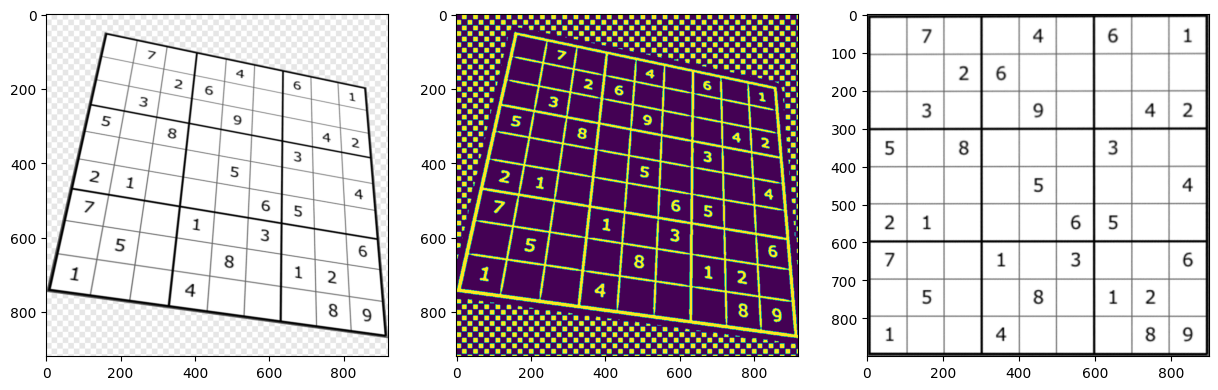

In [3]:
# Opening the Sudoku image
img = cv2.imread('test.png')

#Detecting contours on the image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurry = cv2.GaussianBlur(gray, (5, 5), 5)
thresh = cv2.adaptiveThreshold(blurry, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)
cnts,_ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

# To find the Sudoku grid, we locate the largest square on the image.
location = None
for cnt in cnts:
    approx = cv2.approxPolyDP(cnt, 15, True)
    if len(approx) == 4:
        # Sorting corners in a clockwise order
        rect = np.zeros((4, 2), dtype = "float32")
        cutt = approx[:,0]

        diag_1 = cutt.sum(axis = 1)
        rect[0] = cutt[np.argmin(diag_1)]
        rect[2] = cutt[np.argmax(diag_1)]

        diag_2 = np.diff(cutt, axis = 1)
        rect[1] = cutt[np.argmin(diag_2)]
        rect[3] = cutt[np.argmax(diag_2)]

        location = rect
        break

# Creating a 900x900 square
height = 900
width = 900
pts1 = np.float32([location[0], location[1], location[3], location[2]])
pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

#Fitting the Sudoku puzzle into our square
matrix = cv2.getPerspectiveTransform(pts1, pts2)
board = cv2.warpPerspective(img, matrix, (width, height))

# display result
fig, ax = plt.subplots(1,3, figsize=(15,15))
for i, j in zip(range(len(ax)), [img, thresh, board]):
    ax[i].imshow(j)

In [6]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 17.4 MB/s eta 0:00:00


In [10]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 38.9 MB/s eta 0:00:00


In [11]:
from pulp import *

For our future solution, we will need to know the value of the clue, its row number, and column number. Since we've resized the image to 900x900, we can easily divide the Sudoku into columns by splitting the image into 9 equal sections, and then divide each column into 9 cells. We will pass the parameter allowlist='0123456789' to the model to ensure that it recognizes only numbers.

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

,1,2,3,4,5,6,7,8,9
1,,7,,,4,,6,,1
2,,,2,6,,,,,
3,,3,,,9,,,4,2
4,5,,8,,,,3,,
5,,,,,5,,,,4
6,2,1,,,,6,5,,
7,7,,,1,,3,,,6
8,,5,,,8,,1,2,
9,1,,,4,,,,8,9


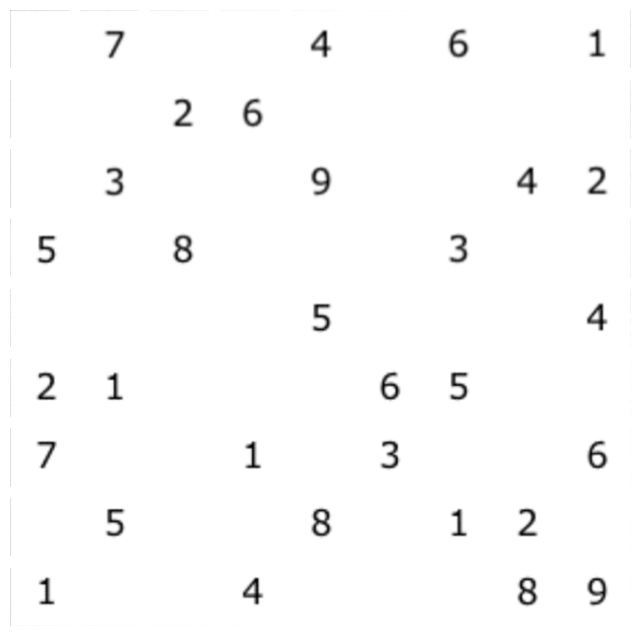

In [7]:
# load model OCR
import easyocr
reader = easyocr.Reader(['en'])

#Creating a DataFrame and a list for recording recognized results
df = pd.DataFrame(index=range(1, 10), columns=range(1, 10))
sudoku_map = []

fig, ax = plt.subplots(9, 9, figsize=(8,8))

#divide our Sudoku into 9 rows and 9 columns and recognize each value
split = np.split(board, 9, axis=1)
for col,j  in enumerate(split):
    digs = np.split(j, 9)
    for row,d in enumerate(digs):

        d = d[10:90,10:90]
        cv2.copyMakeBorder(d,10,10,10,10,cv2.BORDER_CONSTANT)
        ax[row][col].imshow(d)
        ax[row][col].axis('off')


        text = reader.readtext(d, allowlist='0123456789', detail=0)
        if len(text) > 0:
            df.iloc[row, col] = text[0]
            sudoku_map.append([text[0], str(row+1), str(col+1)])

df.fillna('', inplace=True)
df

The final step is to solve the Sudoku puzzle. For this, we'll use the PuLP library.

PuLP is a linear programming library in Python. In our case, we will search for the optimal value for each cell based solely on constraints, as there is no objective function in solving Sudoku.

Here's how we can create lists of numbers from 1 to 9 (possible values for each cell, column numbers, and row numbers) and create PuLP variables from them. In our case, this will be a dictionary of values from 1 to 9, where each value can be either 0 or 1, depending on the truth of the statement. Then, we declare a task with any objective function (minimization or maximization), and instead of a formula, we specify constraints.

In [12]:
nums = [*map(str, [*range(1,10)])] #The list of numbers from 1 to 9 with string data
rows = nums
cols = nums
vals = nums

choices = LpVariable.dicts("Choice", (vals, rows, cols), 0, 1, LpInteger)


prob = LpProblem("Судоку", LpMaximize)
prob += 0, "Целевая функция" # It is set to zero, as we are only interested in finding a value according to the constraints

In [16]:

for r, c in product(rows, cols):
    prob += lpSum([choices[v][r][c] for v in vals]) == 1, ""

for v, r in product(vals, rows):
    prob += lpSum([choices[v][r][c] for c in cols]) == 1, ""

for v, c in product(vals, cols):
    prob += lpSum([choices[v][r][c] for r in rows]) == 1, ""

grid = (range(3), range(3))
subs = [[(rows[3*i+k],cols[3*j+l]) for k,l in product(*grid)] for i,j in product(*grid)]
for v,s in product(vals, subs):
    prob += lpSum([choices[v][r][c] for (r, c) in s]) == 1, ""

In [17]:

for num in sudoku_map:
    prob += choices[num[0]][num[1]][num[2]] == 1, ""

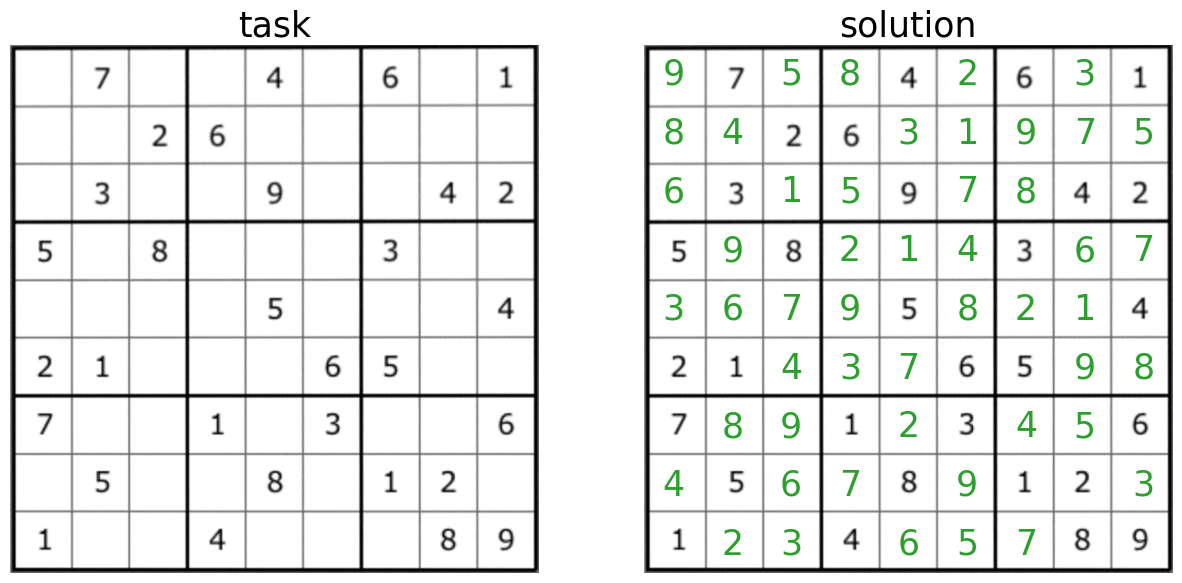

In [19]:

prob.solve()

fig, ax = plt.subplots(1,2, figsize=(15,15))
for a in ax:
    a.axis('off')
    a.imshow(board)

ax[0].set_title('task', fontsize=25)
ax[1].set_title('solution', fontsize=25)


y = 50
for r in rows:
    x = 50
    for c,v in product(cols, vals):
        if choices[v][r][c].value() == 1:
            if [v,r,c] not in sudoku_map:
                ax[1].text(x,y,v, ha='center', va='center', fontsize=25, color='tab:green')
            x += 100
    y += 100